# **I. Giới thiệu**

**Large Language Models (LLMs)** là loại mô hình cho phép người dùng nhập vào một đoạn văn bản với nội dung bất kỳ. Từ đó, mô hình sẽ trả về câu trả lời dưới dạng văn bản, thỏa mãn yêu cầu của người dùng. Một vài ứng dụng LLM là: ChatGPT, Gemini, ...

Trong LLM, **Retrival Augmented Generation (RAG)** là một kỹ thuật giúp LLM cải thiện chất lượng kết quả tạo sinh bằng cách tích hợp nội dung truy vấn được từ một nguồn tài liệu nào đó để trả lời câu hỏi đầu vào.

Project này sẽ xây dựng một chương trình RAG cơ bản trong việc hỏi đáp tài liệu bài học trong khóa AIO2024.

- **Input**: File tài liệu cần hỏi đáp và một câu hỏi liên quan tới nội dung tài liệu
- **Output**: Câu trả lời

Pipeline của project có dạng như sau:
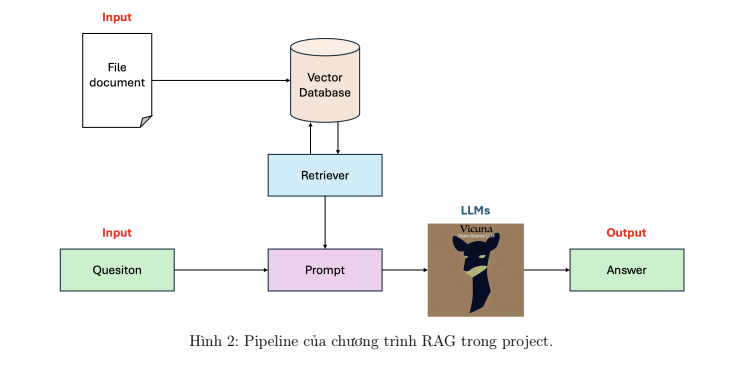



# **II. Cài đặt**

Gồm 2 phần:

- RAG
- Giao diện chatbot sử dụng Chainlit

## **II.I. RAG**

Sử dụng LangChain để xây dựng, các bước thực hiện như sau:

**1. Cài packages cần thiết**

In [ ]:
!pip install -q transformers==4.41.2  # Transformers model
!pip install -q bitsandbytes==0.43.1
!pip install -q accelerate==0.31.0
!pip install -q langchain==0.2.5
!pip install -q langchainhub==0.1.20  # LangChainHub, similar to HuggingFaceHub (maybe)
!pip install -q langchain-chroma==0.1.1  # ChromaDB vector database
!pip install -q langchain-community==0.2.5
!pip install -q langchain-huggingface==0.0.3
!pip install -q langchain-openai==0.1.9
!pip install -q python-dotenv==1.0.1
!pip install -q pypdf==4.2.0
!npm install -g localtunnel
!pip install -q chainlit==1.1.304
!pip install -q numpy==1.24.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.6/974.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.8/332.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.5/559.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

**2. Xây dựng vector database**: Để thực hiện truy vấn RAG cần có CSDL => Thực hiện đưa các nội dung trong file PDF vào CSDL. Các bước thực hiện như sau:

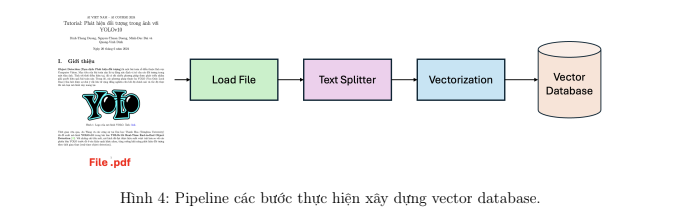

**(a) Import packages**:





In [ ]:
import torch

from transformers import BitsAndBytesConfig
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_huggingface.llms import HuggingFacePipeline
from langchain.memory import ConversationBufferMemory
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain.chains import ConversationalRetrievalChain
from langchain_community.document_loaders import PyPDFLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain import hub

**(b) Đọc file PDF**: Từ một file PDF cho trước, sử dụng class PyPDFLoader để đọc file PDF

In [ ]:
FILE_PATH = "/content/YOLOv10_Tutorials.pdf"
loader = PyPDFLoader(FILE_PATH)
documents = loader.load()

**(c) Khởi tạo bộ tách văn bản (text splitter)**: Trong hầu hết trường hợp, vùng thông tin cần truy vấn chỉ là một câu nào đó trong file văn bản lớn. Do đó, sẽ tốt hơn khi chia file văn bản thành nhiều đoạn văn bản nhỏ, và coi mỗi văn bản nhỏ là một tài liệu trong CSDL.

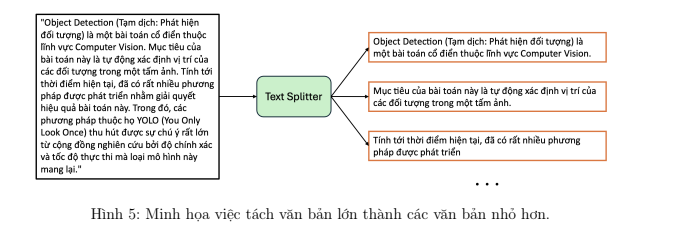

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000,
                                               chunk_overlap=100)

"""
Chunk Size: The text splitter will divide the original text into smaller segments,
  each containing up to 1000 characters.

Chunk Overlap: To ensure that important information that might span across the boundary of chunks is not lost,
  the splitter will include some overlap. Each chunk will share 100 characters with the previous and next chunk.
"""

'\nChunk Size: The text splitter will divide the original text into smaller segments, \n  each containing up to 1000 characters.\n  \nChunk Overlap: To ensure that important information that might span across the boundary of chunks is not lost, \n  the splitter will include some overlap. Each chunk will share 100 characters with the previous and next chunk.\n'

In [ ]:
docs = text_splitter.split_documents(documents)

print("Number of sub-documents:", len(docs))
print(docs[0])

Number of sub-documents: 33
page_content='AI VIET NAM – AI COURSE 2024\nTutorial: Phát hiện đối tượng trong ảnh với\nYOLOv10\nDinh-Thang Duong, Nguyen-Thuan Duong, Minh-Duc Bui và\nQuang-Vinh Dinh\nNgày 20 tháng 6 năm 2024\nI. Giới thiệu\nObject Detection (Tạm dịch: Phát hiện đối tượng) là một bài toán cổ điển thuộc lĩnh vực\nComputer Vision. Mục tiêu của bài toán này là tự động xác định vị trí của các đối tượng trong\nmột tấm ảnh. Tính tới thời điểm hiện tại, đã có rất nhiều phương pháp được phát triển nhằm\ngiải quyết hiệu quả bài toán này. Trong đó, các phương pháp thuộc họ YOLO (You Only Look\nOnce) thu hút được sự chú ý rất lớn từ cộng đồng nghiên cứu bởi độ chính xác và tốc độ thực\nthi mà loại mô hình này mang lại.\nHình 1: Logo của mô hình YOLO. Ảnh: link.\nThời gian vừa qua, Ao Wang và các cộng sự tại Đại học Thanh Hoa (Tsinghua University)\nđã đề xuất mô hình YOLOv10 trong bài báo YOLOv10: Real-Time End-to-End Object\nDetection [10]. Với những cải tiến mới, mô hình đã đạt đượ

**(d) Khởi tạo instance vectorization**: Embed các đoạn văn bản thành vector để dễ dàng tính toán và so sánh hơn.

In [ ]:
embedding = HuggingFaceEmbeddings()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

**(e) Khởi tạo Vector Database**: Đưa các thông tin từ kết quả `text_splitter` và `embedding` vào hàm dùng để khởi tạo Vector Database.

In [ ]:
vector_db = Chroma.from_documents(documents=docs,
                                  embedding=embedding)

retriever = vector_db.as_retriever()

Thực hiện truy vấn thử một câu hỏi sau:

In [ ]:
test_result = retriever.invoke("What is YOLO?")

print("Number of relevant documents:", len(test_result))

Number of relevant documents: 4


**3. Khởi tạo mô hình ngôn ngữ lớn**: Sử dụng mô hình Vicuna, mã nguồn mở, hiệu suất ổn, phản hồi tốt với tiếng Việt. Thông tin thêm về mô hình có thể tìm thấy tại [đây](https://lmsys.org/blog/2023-03-30-vicuna/).

Một vấn đề nói chung của các LLM là yêu cầu tài nguyên phần cứng khá lớn. Vì vậy, để khởi tạo được mô hình Vicuna trên Colab cần thực hiện các bước sau:

**(a) Khai báo một số cài đặt cần thiết cho mô hình**

In [ ]:
nf4_config = BitsAndBytesConfig (
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch.bfloat16
)

**(b) Khởi tạo model và tokenizer**

- **Tokenizer**: Breaks down text into tokens represented as numbers, due to pre-defined rules.

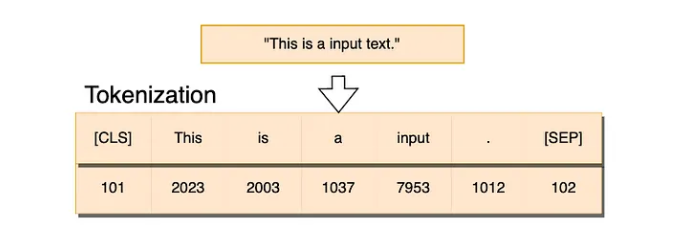

- **Embedding**: Transforms tokens into numerical vectors.

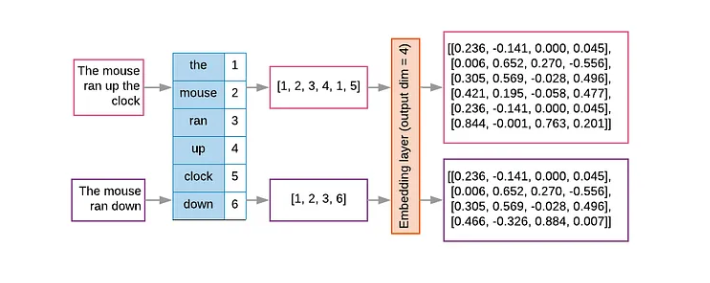

In [ ]:
MODEL_NAME = "lmsys/vicuna-7b-v1.5"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=nf4_config,
    low_cpu_mem_usage=True
)

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/162 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:520: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

**(c) Tích hợp tokenizer và model thành một pipeline**

In [ ]:
model_pipeline = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    pad_token_id=tokenizer.eos_token_id,
    device_map="auto"
)

In [ ]:
llm = HuggingFacePipeline(
    pipeline=model_pipeline
)

**4. Chạy chương trình**: Kết hợp vector database, retriever, model Vicuna để tạo thành chương trình RAG

In [ ]:
def format_docs(docs):
  return "\n\n".join(doc.page_content for doc in docs)

In [ ]:
prompt = hub.pull("rlm/rag-prompt")

rag_chain = (
    {"context": retriever | format_docs,
     "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

USER_QUESTION = "Tập dữ liệu sử dụng để huấn luyện YOLOv10 trong tài liệu là gì?"
output = rag_chain.invoke(USER_QUESTION)
answer = output.split("Answer:")[1].strip()
print(answer)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:520: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


The YOLOv10 model is trained using a dataset of images. The dataset is not specified in the given context, but it is mentioned that YOLOv10 has better performance than previous versions in terms of model parameters and inference speed while maintaining or improving accuracy. The pre-trained models can be downloaded from a GitHub repository, and the model can be initialized with the downloaded file. The context also mentions the use of GELAN for improved accuracy and speed.
